In [1]:
%load_ext autoreload
%autoreload 2

from calc_del_lambda import import_lab_frame_spectra
lab = import_lab_frame_spectra('/home/agoga/Documents/nreshk/data/LabSpectra/', resolution=0)#,res*10)

In [10]:
#BEFORE RUNING THIS MAKE SURE CALC_DEL_LAMBDA HAS A LOCAL WIDTH OF AROUND 50

import scipy as sc
from scipy import interpolate

import astropy.io.fits
import numpy as np
import os

from calc_shk import calc_targOlapf
from calc_shk import calc_shk
from calc_shk import smart_calc_shk


from calc_del_lambda import tmp_find_del_lam
from calc_del_lambda import lamda_zoom
from calc_del_lambda import pdf_from_data
from helpers import mkdir_p
from helpers import bad_spec_detection

from mk_flatolap import mk_flatolap
from matplotlib import pyplot as plt

from astropy.time import Time
from matplotlib.backends.backend_pdf import PdfPages


def print_header(hdu):
    for i in hdu[0].header:
        print(i + ': ' + str(hdu[0].header[i]))
def mjd_from_hdu(hdu):
    return hdu[0].header['MJD-OBS']

#https://stackoverflow.com/questions/47725773/finding-an-integer-key-of-a-python-dict-that-is-closest-to-a-given-integer
def find_nearest_mjd(dd,mjd):
    low = max([d for d in dd if d<= mjd])
    high = min([d for d in dd if d>= mjd])
    nearkey = low if mjd - low <= high - mjd else high
    return nearkey
def closestKey(dic, key):
    diff = {k:abs(k - key) for k in dic}
    return min(diff, key=diff.get)


dataPath ='/home/agoga/Documents/nreshk/data/smarts/'
padWidth= 1000
hduList = []
data = [[],[]]
for root, dirs, files in os.walk(dataPath):
    dirs[:] = [d for d in dirs if d not in exclude]
    
    for file in files:
        if file.endswith(".fits"):
            hdu = astropy.io.fits.open(os.path.join(root, file))
            
            #print_header(hdu)
            hduList.append(hdu)
            spec = hdu[0].data[0][0]
            
            lamStep = hdu[0].header['CD1_1']#lamda grid step value
            lamStart = hdu[0].header['CRVAL1'] #labda grid start value

            lamGrid = lamStart + np.arange(len(spec))*lamStep
            
            
            #RICKY HACK
            #we want the lamda grid to be rougly 10 times longer in the same range
            hackedValue = 10
            adjLamGrid = lamStart + np.arange(len(spec)*hackedValue)*lamStep/10#/10 bc angstroms
            #print(lamGrid)
            #print(adjLamGrid)
            interpfunc = interpolate.interp1d(lamGrid, spec, kind='linear',fill_value='extrapolate')
            
            adjSpec=interpfunc(adjLamGrid)
            #E HACK
            
            #removed padding as it does not affect TODO TEST once proper correlation working
            #lamda grid padding 
            #backPad = lamGrid[-1] + np.arange(padWidth)*lamStep
            #frontPad = np.flip(lamGrid[0] - np.arange(padWidth)*lamStep)
            
            #lamGrid = np.append(np.append(frontPad,lamGrid),backPad)
            
            #need to pad the edges with 0's
            #spec = np.pad(spec,pad_width=padWidth,mode='constant',constant_values=0)
            #end padding
            
            #both grids are in angstroms but that's ugly
            lamGrid = lamGrid/10
            labGrid=lab[0]/10
            
            
            
            #plt.figure(figsize=(20,6))
            #plt.plot(lamGrid,spec,'g-')
            #plt.show()
            #plt.close()
            
            
            
            #gausLab = sc.ndimage.filters.gaussian_filter(labSpc,.1/dLam)
            out = tmp_find_del_lam(labGrid,lab[1],lamGrid, spec,1)
           # print(out)
            dLam = out[0]
            labSpec = out[2]

            #RICKY HACK
            #this is because our 
           # dLam = dLam
            #E
            
            
            #plt.figure(figsize=(20,6))
           # plt.plot(lamGrid,out[2]*1000,'b-')
            #plt.plot(lamGrid,spec,'g-')
            ##plt.show()
            #plt.close()
            
            print('lamd adj: ' + str(dLam))
            shkRet = smart_calc_shk(lamGrid-dLam, spec, 0, teff=6200)
            #shkRet = smart_calc_shk(adjLamGrid-dLam, adjSpec, 0, teff=6200)
            #shkRet = calc_shk(adjLamGrid/10-dLam, adjSpec, 0, teff=6200)
            shk = shkRet[0]
            windows = shkRet[1]
            
            
            
            
            #HELL TIME CONVERSION
            import time
            from astropy.time import Time
            fileDate = hdu[0].header['WAVEFILE'][4:]
            date = time.strptime(fileDate, "%a %b %d %H:%M:%S %Y")
            iso = time.strftime('%Y-%m-%dT%H:%M:%SZ', date)
            
            t= Time(iso, format='isot')
            t.format = 'decimalyear'
            ##E
            label = str(t.value)
            print("shk: " + str(shk) + " for obs: "+label)
            mkdir_p("output/"+"SMARTS/")
            #pdf_from_data(lamGrid, labSpec,lamGrid-dLam, spec, spec,windows, "output/"+"SMARTS/",label,.3)
            
            data[0].append(t.value)
            data[1].append(shkRet[2])

lamd adj: 0.03129481090164064
shk: 0.24113633821720165 for obs: 2008.1227304062943
lamd adj: 0.015234685850777144
shk: 0.24504805623932763 for obs: 2008.1227304062943
lamd adj: -0.006296093239709815
shk: 0.23783256967825228 for obs: 2008.2051531193079
lamd adj: -0.00038005491124649607
shk: 0.2411640272275588 for obs: 2008.2051531193079
lamd adj: -0.00928833037672286
shk: 0.2456976332796045 for obs: 2008.5191245446265
lamd adj: -0.009449544578705537
shk: 0.24677513843750437 for obs: 2008.5191245446265
lamd adj: -0.015546924035015607
shk: 0.24339490040353845 for obs: 2008.5618878390003
lamd adj: -0.01597412248871445
shk: 0.24942141181464197 for obs: 2008.5618878390003
lamd adj: -0.014652419958094104
shk: 0.23300867915236453 for obs: 2008.568637295082
lamd adj: -0.015077235734502283
shk: 0.23962462832194023 for obs: 2008.568637295082
lamd adj: -0.024305969377033203
shk: 0.22833826984805333 for obs: 2008.5874636333738
lamd adj: -0.021435504207015788
shk: 0.23232655679329028 for obs: 2008.5

lamd adj: 0.0270734624152728
shk: 0.25180306370425565 for obs: 2011.1095986808728
lamd adj: 0.012240842936531453
shk: 0.2487057583755226 for obs: 2011.1511615296804
lamd adj: 0.015470349747337441
shk: 0.24258533610801702 for obs: 2011.1511615296804
lamd adj: 0.009708553859949932
shk: 0.24610064879770246 for obs: 2011.1826716768137
lamd adj: 0.02677521821615672
shk: 0.25206707309335535 for obs: 2011.1826716768137
lamd adj: -0.0028054923196412927
shk: 0.24344811857529092 for obs: 2011.2570149670219
lamd adj: 0.0027038368070531667
shk: 0.2446031669095502 for obs: 2011.2570149670219
lamd adj: -0.01706722466293739
shk: 0.24726845316607102 for obs: 2011.4376178970067
lamd adj: -0.018037821294399962
shk: 0.2481703437104185 for obs: 2011.4376178970067
lamd adj: -0.013742735827032877
shk: 0.25400404521125675 for obs: 2011.4872254249112
lamd adj: -0.013133300787891235
shk: 0.25645502255929553 for obs: 2011.4872254249112
lamd adj: -0.017499279461971648
shk: 0.24689388666359682 for obs: 2011.54834

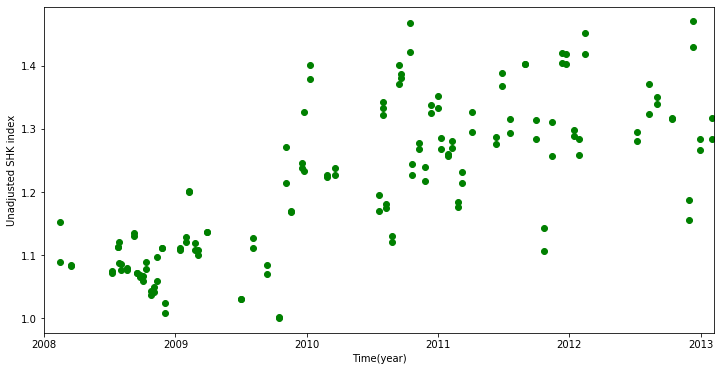

/home/agoga/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/agoga/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


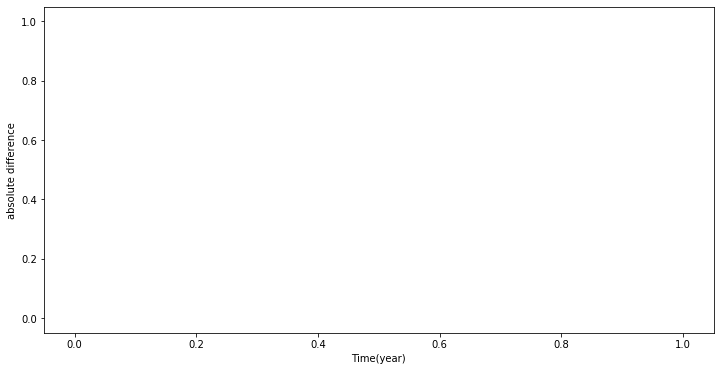

ValueError: x and y must have same first dimension, but have shapes (0,) and (145,)

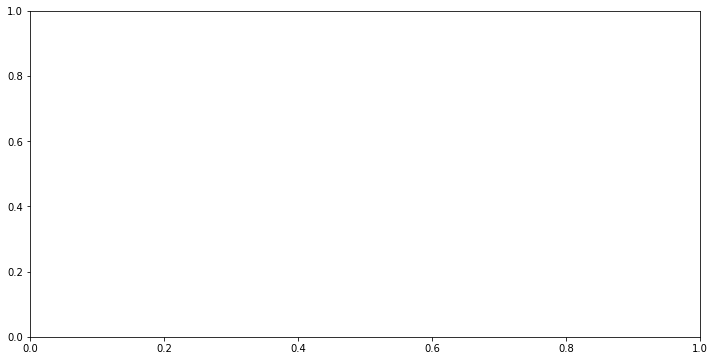

In [12]:
shkArray = np.asarray(data)

realFile = open(dataPath+"HD17051.txt", "r")
realData = realFile.readlines()

perfData = [[],[]]
for x in realData:
    cDate = x.split(' ')[0]
    cShk = x.split(' ')[1]
    #print(cDate + ' : ' + cShk)
    perfData[0].append(float(cDate))
    perfData[1].append(float(cShk))
realFile.close()

#siteArray = np.asarray(sites)
plt.figure(figsize=(12,6))    
#t= Time(shkArray[0], format='mjd')
#t.format = 'decimalyear'
plt.xlim([2008,2013.1])
#plt.ylim([.18,.45])
#print(perfData[0])
plt.plot(shkArray[0],shkArray[1], 'go')
#plt.plot(perfData[0],perfData[1], 'ko')

#plt.title('HD '+setName+' magnetic activity cycle')
plt.xlabel('Time(year)')
plt.ylabel('Unadjusted SHK index')
plt.savefig('output/SmartsSHKs.pdf')
#plt.savefig('output/'+setName+'shk_time_series.pdf')
plt.show()
plt.close()


diffArr = (shkArray[1]-perfData[1])
tArr  = shkArray[0][abs(diffArr)< .7] 
diffArr = diffArr[abs(diffArr)< .7]
mean = np.mean(diffArr)


plt.figure(figsize=(12,6))  
plt.plot(tArr,diffArr,'ko')
plt.xlabel('Time(year)')
plt.ylabel('absolute difference')
plt.savefig('output/SmartsDifferences.pdf')
plt.show()
plt.close()

plt.figure(figsize=(12,6))  
plt.plot(tArr,(shkArray[1]/perfData[1])-1,'ko')
plt.xlabel('Time(year)')
plt.ylabel('ratio(adam/perfect) - 1')
plt.savefig('output/SmartsDivision.pdf')
plt.show()
plt.close()

print('mean: '+str(mean))
print(abs(diffArr-mean)/mean*100)